In [1]:
import os, glob
import sys
import json
from PIL import Image
from collections import Counter

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import tifffile as tiff
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2

from sklearn.model_selection import KFold

sys.path.append("detection-wheel")

In [2]:
EPOCHS = 30

In [3]:

import os
import numpy as np
import torch
from PIL import Image


class PennFudanDatasetVal(torch.utils.data.Dataset):
    def __init__(self, imgs, masks, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = imgs#sorted(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/image/*.png'))
        self.masks = masks#sorted(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/mask/*.png'))

    def __getitem__(self, idx):
        # load images and masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = Image.open(img_path).convert("RGB")
        
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path).convert('L')
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        #masks = (mask == obj_ids[:, None, None])
        #print((obj_ids[:, None, None]).shape)
        #masks = mask == obj_ids[:, None, None]
        masks = [np.where(mask== obj_ids[i, None, None],1,0) for i in range(len(obj_ids))]
        masks = np.array(masks)

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        try:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            #print(area,area.shape,area.dtype)
        except:
            area = torch.tensor([[0],[0]])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        #print(masks.shape)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:

import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import numpy as np
import torch
from PIL import Image
from torchvision.transforms import functional as F, InterpolationMode
from skimage.draw import polygon

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, masks, mode='train'):
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = imgs
        self.masks = masks

        self.mode = mode
        
        
        labels_file = "/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/polygons.jsonl"
        with open(labels_file, 'r') as json_file:
            self.json_labels = [json.loads(line) for line in json_file]
            
        # get index for each 'id' 
        indices_map = {}
        for indx, label in enumerate(self.json_labels):
            indices_map[label['id']] = indx
        
        self.indices_map = indices_map
        
        if self.mode == 'train':
            self.alb_transform = A.Compose([
                
                
                    A.Rotate(limit=90, p=0.9),
                    A.ShiftScaleRotate(p=0.5),
                    A.RandomBrightnessContrast(p=0.2),
                    A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.2),
                    A.RandomGamma(p=0.2),
                    # A.RandomCrop(height=256, width=256, p=0.5),
                    A.RandomResizedCrop(height=512, width=512, p=0.5),
                    A.Affine(p=0.5),
                    A.Downscale(scale_min=0.1, scale_max=0.5, p=0.5),
                    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, mask_fill_value=0, p=0.3),
                    A.ShiftScaleRotate(shift_limit=0, scale_limit=0, p=0.3),
                    
                    
                    A.Normalize(
                        mean= [0] * 3,
                        std= [1] * 3
                    ),
                
                
                    ToTensorV2(transpose_mask=True),
                ])
        else:
            self.alb_transform = A.Compose([
                    
                    A.Normalize(
                        mean= [0] * 3,
                        std= [1] * 3
                    ),
                
                
                    ToTensorV2(transpose_mask=True),
                ])

    def __getitem__(self, idx):
        
        num_objs = 0
        while num_objs == 0:
        
            idx = np.random.randint(0, len(self.imgs))
            
            # load images and masks
            img_path = self.imgs[idx]
            mask_path = self.masks[idx] # '/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/mask/0006ff2aa7cd_mask.png'
            
            
            
            # load image
            img = Image.open(img_path).convert("RGB")
            img = np.array(img)
            
            # load mask, but first get the id
            mask_id = mask_path.split('/')[-1].split('_')[0]
            
            mask = np.zeros((512, 512), dtype=np.float32)
            
            
            mask_id_indx = self.indices_map[mask_id]
            for annot in self.json_labels[mask_id_indx]['annotations']:
                cords = annot['coordinates']
                if annot['type'] == "blood_vessel":
                    for cord in cords:
                        rr, cc = polygon(np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord]))
                        mask[rr, cc] = 1
            
        
            # ---------------- Augmentations ----------------
            
            
            
            # albumentations
            transformed = self.alb_transform(image=img, mask=mask)
            
            img = transformed['image']
            mask = transformed['mask'].numpy()
            
            # return img, mask
            
            # print(img.shape, mask.shape)
            mask_uint8 = np.where(mask > 0.5, 1, 0).astype(np.uint8) * 255
                
            num_outputs, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8)
            label_masks = [labels == i for i in range(num_outputs)]
            masks = []
            for m in label_masks:
                mask_m = mask * m
                if np.sum(mask_m) > 80:
                    masks.append(mask_m)
                    
            
            # -----------------------------------------------
            
            # get bounding box coordinates for each mask
            num_objs = len(masks)
            boxes = []
            
            
            
            
            
        
        
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
    
    
        

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        
        try:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            #print(area,area.shape,area.dtype)
        except:
            area = torch.tensor([[0],[0]])
        
        
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target['num_objs'] = torch.tensor(num_objs)      
        target["image_id"] = image_id  
        target["area"] = area
        target["iscrowd"] = iscrowd

                
        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
train_img = sorted(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/image/*.png'))
train_mask = sorted(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/mask/*.png'))
dataset_train = PennFudanDataset(train_img, train_mask,  mode='train')

/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1554: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/torch/csrc/utils/tensor_new.cpp:245.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


10


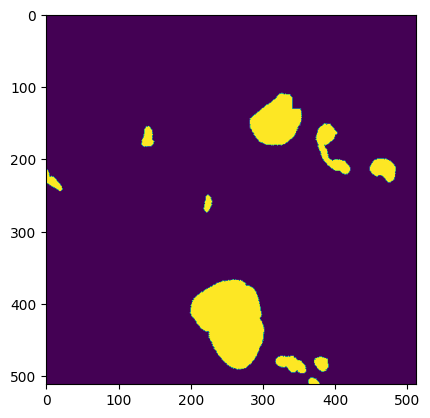

In [6]:
img, target = dataset_train[0]



masks = [m for m in target['masks'].numpy()]
print(len(masks))

plt.imshow(np.sum(masks, axis=0))

In [7]:
import torchvision
from torchvision.models import list_models
detection_models = list_models(module=torchvision.models.detection)
detection_models

['fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcos_resnet50_fpn',
 'keypointrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'retinanet_resnet50_fpn',
 'retinanet_resnet50_fpn_v2',
 'ssd300_vgg16',
 'ssdlite320_mobilenet_v3_large']

In [8]:
import torchvision
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.resnet import ResNet50_Weights

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT", weights_backbone=ResNet50_Weights.IMAGENET1K_V2)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [9]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomIoUCrop())
        transforms.append(T.RandomZoomOut())
        transforms.append(T.RandomPhotometricDistort())
        transforms.append(T.ScaleJitter())
        transforms.append(T.RandomShortestSize())
        
    return T.Compose(transforms)

In [10]:
from engine import train_one_epoch, evaluate
import utils

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
n_imgs = len(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/image/*'))
n_imgs



1622

In [13]:
# import sys

# # Create a custom function to log output
# def log_output(text):
#     with open('output.log', 'a') as f:
#         f.write(text)

# # Redirect stdout to the custom log function
# sys.stdout.write = log_output


In [14]:

kf = KFold(n_splits=5, shuffle=True, random_state=43)
for i, (train_index, test_index) in enumerate(kf.split(range(n_imgs))):
    if i!=0: continue
    all_imgs = sorted(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/image/*.png'))
    all_masks = sorted(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/mask/*.png'))
    
    all_imgs = np.array(all_imgs)
    all_masks = np.array(all_masks)
    train_img = all_imgs[train_index]
    train_mask = all_masks[train_index]
    
    
    # train_img = train_img
    
    val_img = all_imgs[test_index]
    val_mask = all_masks[test_index]
    dataset_train = PennFudanDataset(train_img, train_mask, mode='train')
    dataset_val = PennFudanDatasetVal(val_img, val_mask, get_transform(train=False))
    train_dl = torch.utils.data.DataLoader(
        dataset_train, batch_size=4, shuffle=True, num_workers=os.cpu_count(), pin_memory=True, drop_last=True, collate_fn=utils.collate_fn)
    val_dl = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False, num_workers=os.cpu_count(), pin_memory=True,collate_fn=utils.collate_fn)
                                                        #os.cpu_count()
    
    
    model = get_model_instance_segmentation(num_classes=2)
    
    print("Loading weights")
    ckpt_files = os.listdir('ckpts')
    # Load initial checkpoint
    weights = torch.load(f"ckpts/{ckpt_files[0]}")

    # Sum all weights
    for ckpt_file in ckpt_files[1:]:
        ckpt = torch.load(f"ckpts/{ckpt_file}")
        for k in weights.keys():
            if weights[k].dtype is torch.float32:   # Check for float tensor
                weights[k] += ckpt[k]

    # Average weights
    for k in weights.keys():
        if weights[k].dtype is torch.float32:   # Check for float tensor
            weights[k] /= len(ckpt_files)

    model.load_state_dict(weights)
    print("Weights loaded")
    
    
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=1e-8)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # set linear warmup scheduler, with constant learning rate after warmup
    
    
    # scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
    #                                                 base_lr=2e-5, 
    #                                                 max_lr=3e-3, 
    #                                                 step_size_up=40, 
    #                                                 step_size_down=40, 
    #                                                 mode='triangular2', 
    #                                                 cycle_momentum=False)

    # scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,start_factor=0.01,
    #                                         end_factor=1,
    #                                         total_iters=10)

    
    for epoch in range(EPOCHS):
        train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=50)
        evaluate(model, val_dl, device=device)
        # scheduler.step()
        model_path = f'ckpts-SWA/fold_{i}_epoch{epoch}.pth' 
        torch.save(model.state_dict(), model_path)
        

Loading weights
Weights loaded


/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, an

Epoch: [0]  [  0/324]  eta: 1:03:11  lr: 0.000000  loss: 0.8451 (0.8451)  loss_classifier: 0.2026 (0.2026)  loss_box_reg: 0.3141 (0.3141)  loss_mask: 0.2731 (0.2731)  loss_objectness: 0.0328 (0.0328)  loss_rpn_box_reg: 0.0226 (0.0226)  time: 11.7007  data: 10.0135  max mem: 6470
Epoch: [0]  [ 50/324]  eta: 0:02:18  lr: 0.000000  loss: 0.7148 (0.8013)  loss_classifier: 0.1606 (0.1875)  loss_box_reg: 0.2787 (0.2919)  loss_mask: 0.2533 (0.2625)  loss_objectness: 0.0261 (0.0366)  loss_rpn_box_reg: 0.0166 (0.0229)  time: 0.3054  data: 0.0973  max mem: 7113
Epoch: [0]  [100/324]  eta: 0:01:25  lr: 0.000000  loss: 0.8034 (0.8177)  loss_classifier: 0.1760 (0.1887)  loss_box_reg: 0.2835 (0.2977)  loss_mask: 0.2652 (0.2662)  loss_objectness: 0.0359 (0.0403)  loss_rpn_box_reg: 0.0202 (0.0248)  time: 0.2128  data: 0.0154  max mem: 7121
Epoch: [0]  [150/324]  eta: 0:01:00  lr: 0.000000  loss: 0.7572 (0.8077)  loss_classifier: 0.1629 (0.1853)  loss_box_reg: 0.2952 (0.2974)  loss_mask: 0.2492 (0.2631

/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, an

Epoch: [1]  [  0/324]  eta: 1:03:11  lr: 0.000000  loss: 0.9363 (0.9363)  loss_classifier: 0.1912 (0.1912)  loss_box_reg: 0.3791 (0.3791)  loss_mask: 0.3074 (0.3074)  loss_objectness: 0.0390 (0.0390)  loss_rpn_box_reg: 0.0195 (0.0195)  time: 11.7028  data: 11.5001  max mem: 7121
Epoch: [1]  [ 50/324]  eta: 0:01:59  lr: 0.000000  loss: 0.8073 (0.8031)  loss_classifier: 0.1911 (0.1919)  loss_box_reg: 0.2876 (0.2942)  loss_mask: 0.2564 (0.2545)  loss_objectness: 0.0327 (0.0400)  loss_rpn_box_reg: 0.0184 (0.0226)  time: 0.2074  data: 0.0009  max mem: 7121
Epoch: [1]  [100/324]  eta: 0:01:22  lr: 0.000000  loss: 0.7870 (0.8091)  loss_classifier: 0.1965 (0.1881)  loss_box_reg: 0.2921 (0.2922)  loss_mask: 0.2636 (0.2615)  loss_objectness: 0.0267 (0.0425)  loss_rpn_box_reg: 0.0201 (0.0248)  time: 0.3466  data: 0.1407  max mem: 7121
Epoch: [1]  [150/324]  eta: 0:00:59  lr: 0.000000  loss: 0.7417 (0.8090)  loss_classifier: 0.1602 (0.1857)  loss_box_reg: 0.2787 (0.2941)  loss_mask: 0.2495 (0.2624

/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, an

Epoch: [2]  [  0/324]  eta: 0:41:03  lr: 0.000000  loss: 0.8743 (0.8743)  loss_classifier: 0.2192 (0.2192)  loss_box_reg: 0.3121 (0.3121)  loss_mask: 0.2545 (0.2545)  loss_objectness: 0.0566 (0.0566)  loss_rpn_box_reg: 0.0320 (0.0320)  time: 7.6023  data: 7.3969  max mem: 7121
Epoch: [2]  [ 50/324]  eta: 0:01:54  lr: 0.000000  loss: 0.7295 (0.7933)  loss_classifier: 0.1655 (0.1839)  loss_box_reg: 0.2635 (0.2845)  loss_mask: 0.2555 (0.2618)  loss_objectness: 0.0315 (0.0416)  loss_rpn_box_reg: 0.0173 (0.0215)  time: 0.2067  data: 0.0014  max mem: 7121
Epoch: [2]  [100/324]  eta: 0:01:21  lr: 0.000000  loss: 0.7566 (0.7881)  loss_classifier: 0.1884 (0.1855)  loss_box_reg: 0.2854 (0.2838)  loss_mask: 0.2503 (0.2600)  loss_objectness: 0.0253 (0.0381)  loss_rpn_box_reg: 0.0142 (0.0207)  time: 0.3264  data: 0.1326  max mem: 7121
Epoch: [2]  [150/324]  eta: 0:01:00  lr: 0.000000  loss: 0.8245 (0.8026)  loss_classifier: 0.1991 (0.1887)  loss_box_reg: 0.2991 (0.2912)  loss_mask: 0.2609 (0.2629) 

/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, an

Epoch: [3]  [  0/324]  eta: 0:40:50  lr: 0.000000  loss: 0.7261 (0.7261)  loss_classifier: 0.1682 (0.1682)  loss_box_reg: 0.2611 (0.2611)  loss_mask: 0.2495 (0.2495)  loss_objectness: 0.0241 (0.0241)  loss_rpn_box_reg: 0.0231 (0.0231)  time: 7.5618  data: 7.3601  max mem: 7121
Epoch: [3]  [ 50/324]  eta: 0:01:50  lr: 0.000000  loss: 0.7337 (0.7683)  loss_classifier: 0.1669 (0.1764)  loss_box_reg: 0.2434 (0.2737)  loss_mask: 0.2611 (0.2566)  loss_objectness: 0.0279 (0.0390)  loss_rpn_box_reg: 0.0162 (0.0225)  time: 0.2034  data: 0.0022  max mem: 7121
Epoch: [3]  [100/324]  eta: 0:01:24  lr: 0.000000  loss: 0.7829 (0.7870)  loss_classifier: 0.1839 (0.1811)  loss_box_reg: 0.2741 (0.2835)  loss_mask: 0.2559 (0.2600)  loss_objectness: 0.0400 (0.0396)  loss_rpn_box_reg: 0.0190 (0.0228)  time: 0.3041  data: 0.1074  max mem: 7121
Epoch: [3]  [150/324]  eta: 0:00:58  lr: 0.000000  loss: 0.8289 (0.7930)  loss_classifier: 0.1869 (0.1823)  loss_box_reg: 0.3296 (0.2885)  loss_mask: 0.2663 (0.2605) 

/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, an

Epoch: [4]  [  0/324]  eta: 0:18:36  lr: 0.000000  loss: 0.5047 (0.5047)  loss_classifier: 0.1031 (0.1031)  loss_box_reg: 0.1273 (0.1273)  loss_mask: 0.2553 (0.2553)  loss_objectness: 0.0147 (0.0147)  loss_rpn_box_reg: 0.0044 (0.0044)  time: 3.4455  data: 3.2425  max mem: 7121
Epoch: [4]  [ 50/324]  eta: 0:02:05  lr: 0.000000  loss: 0.7316 (0.7859)  loss_classifier: 0.1710 (0.1784)  loss_box_reg: 0.2630 (0.2786)  loss_mask: 0.2609 (0.2588)  loss_objectness: 0.0258 (0.0430)  loss_rpn_box_reg: 0.0158 (0.0271)  time: 0.1959  data: 0.0004  max mem: 7121
Epoch: [4]  [100/324]  eta: 0:01:27  lr: 0.000000  loss: 0.7325 (0.7880)  loss_classifier: 0.1766 (0.1816)  loss_box_reg: 0.2686 (0.2841)  loss_mask: 0.2495 (0.2585)  loss_objectness: 0.0256 (0.0407)  loss_rpn_box_reg: 0.0124 (0.0231)  time: 0.1942  data: 0.0002  max mem: 7121
Epoch: [4]  [150/324]  eta: 0:01:00  lr: 0.000000  loss: 0.7488 (0.7725)  loss_classifier: 0.1664 (0.1765)  loss_box_reg: 0.2647 (0.2781)  loss_mask: 0.2617 (0.2575) 

/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, an

Epoch: [5]  [  0/324]  eta: 1:03:18  lr: 0.000000  loss: 0.6980 (0.6980)  loss_classifier: 0.1544 (0.1544)  loss_box_reg: 0.2631 (0.2631)  loss_mask: 0.2422 (0.2422)  loss_objectness: 0.0301 (0.0301)  loss_rpn_box_reg: 0.0082 (0.0082)  time: 11.7224  data: 11.5181  max mem: 7121
Epoch: [5]  [ 50/324]  eta: 0:02:01  lr: 0.000000  loss: 0.8069 (0.7851)  loss_classifier: 0.1821 (0.1828)  loss_box_reg: 0.2841 (0.2825)  loss_mask: 0.2632 (0.2596)  loss_objectness: 0.0324 (0.0399)  loss_rpn_box_reg: 0.0202 (0.0202)  time: 0.2456  data: 0.0464  max mem: 7121
Epoch: [5]  [100/324]  eta: 0:01:19  lr: 0.000000  loss: 0.7649 (0.7816)  loss_classifier: 0.1742 (0.1810)  loss_box_reg: 0.2557 (0.2821)  loss_mask: 0.2522 (0.2593)  loss_objectness: 0.0266 (0.0388)  loss_rpn_box_reg: 0.0154 (0.0204)  time: 0.2048  data: 0.0007  max mem: 7121
Epoch: [5]  [150/324]  eta: 0:00:59  lr: 0.000000  loss: 0.8392 (0.7987)  loss_classifier: 0.1797 (0.1860)  loss_box_reg: 0.3224 (0.2917)  loss_mask: 0.2704 (0.2604

/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_3575832/1958983998.py:151: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, an

Epoch: [6]  [  0/324]  eta: 0:44:41  lr: 0.000000  loss: 0.5708 (0.5708)  loss_classifier: 0.1240 (0.1240)  loss_box_reg: 0.1783 (0.1783)  loss_mask: 0.2368 (0.2368)  loss_objectness: 0.0269 (0.0269)  loss_rpn_box_reg: 0.0049 (0.0049)  time: 8.2767  data: 8.0636  max mem: 7121
Epoch: [6]  [ 50/324]  eta: 0:02:14  lr: 0.000000  loss: 0.8426 (0.8160)  loss_classifier: 0.1852 (0.1920)  loss_box_reg: 0.2959 (0.2990)  loss_mask: 0.2606 (0.2629)  loss_objectness: 0.0295 (0.0406)  loss_rpn_box_reg: 0.0212 (0.0215)  time: 0.2083  data: 0.0002  max mem: 7121


KeyboardInterrupt: 